# Testing the tracking function: Ellipse Test
In this test of the tracker function, we're going to look at the ability of the tracker to find matches and accurately get the location and orientation of the "floes" as a function of area and eccentricity. Ellipses were generated with orientations from 0 to 9 degrees. We expect circles to fail to be tracked. All centroid positions will stay constant.

In [5]:
using Pkg;
Pkg.activate("calval")
Pkg.precompile()

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/notebooks/calval`


In [6]:
using IceFloeTracker
using DataFrames, Statistics, CSV, Dates

Some questions:
* Is load or loadimg preferred?
* What is the best way in Julia to operate on a series of objects? List comprehension? For loop?

In [7]:
# Set thresholds from file
mc_thresholds = IceFloeTracker.mc_thresholds

# Alternatively load the defaults:
# condition_thresholds = IceFloeTracker.condition_thresholds
ct = (search_thresholds = 
        (dt = (30.0, 100.0, 1300.0),
         dist = (200, 250, 300)),
      small_floe_settings = (minimumarea = 100,
                             arearatio = 0.18,
                             majaxisratio = 0.1,
                             minaxisratio = 0.15,
                             convexarearatio = 0.2),
      large_floe_settings = (minimumarea = 1200,
                             arearatio = 0.28,
                             majaxisratio = 0.1,
                             minaxisratio = 0.12,
                             convexarearatio = 0.14))

(search_thresholds = (dt = (30.0, 100.0, 1300.0), dist = (200, 250, 300)), small_floe_settings = (minimumarea = 100, arearatio = 0.18, majaxisratio = 0.1, minaxisratio = 0.15, convexarearatio = 0.2), large_floe_settings = (minimumarea = 1200, arearatio = 0.28, majaxisratio = 0.1, minaxisratio = 0.12, convexarearatio = 0.14))

In [8]:
# Load the images from file
image_names = ["ellipses_00"*string(idx)*"deg.png" for idx in range(0, 9)];
images = [IceFloeTracker.load(joinpath("../data/synthetic_ellipse_images/", fname))
            for fname in image_names];

# Generate some fake dates
passtimes = collect(Date(2019,3,1):Day(1):Date(2019,3,10))

# Add labels and get region properties
labeled_images = IceFloeTracker.label_components.(images);
props = IceFloeTracker.regionprops_table.(labeled_images);

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/dwatkin2/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'AttributeError'>
AttributeError("'list' object has no attribute 'ndim'")
  File "/Users/dwatkin2/.julia/conda/3/lib/python3.11/site-packages/skimage/measure/_regionprops.py", line 1023, in regionprops_table
  File "/Users/dwatkin2/.julia/conda/3/lib/python3.11/site-packages/skimage/measure/_regionprops.py", line 1295, in regionprops


To run the tracker, we need to add some additional information. Each object (floe) needs to be added into the dataframe, then we also need the psi-s curve summarizing the edge properties of each object.

In [10]:
# add binary masks
greaterthan0(x) = x .> 0
IceFloeTracker.addfloemasks!(props, greaterthan0.(labeled_images));
IceFloeTracker.add_passtimes!(props, passtimes);
IceFloeTracker.addψs!(props);
IceFloeTracker.adduuid!(props);

# Test images: ellipses
Shown below are two members of the test image set. These are ellipses ranging from circles on the left to an oblong shape on the right. We expect the tracker to fail to track the circles, and are looking for a minimum eccentricity where we can get the change in orientation with confidence.

Each image has 40 ellipses on it, and we have a series of 10 images. If the floes were tracked perfectly, we'd have as dataframe at the end with 400 entries: 10 time steps for each of 40 floes.

In [11]:
using Images: mosaicview

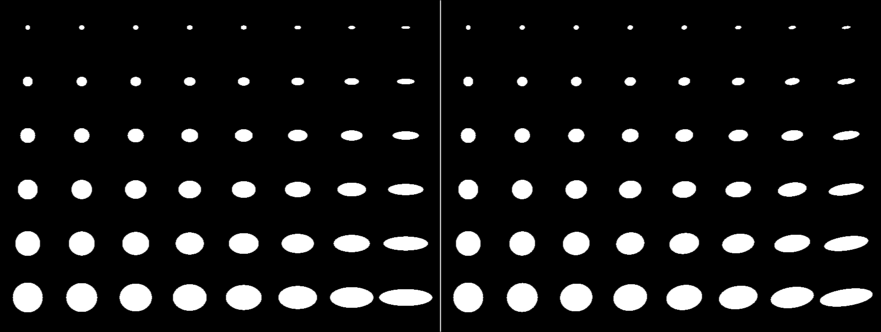

In [12]:
mosaicview(images[1], images[9], npad=2, fillvalue=1, ncol=2)

Finally, we can run the tracker on the list of props matrices.

In [13]:
track_results = IceFloeTracker.long_tracker(props, ct, mc_thresholds);

In [56]:
# Select the data columns (columns with scalars, not vectors or arrays)
track_results[!, :eccentricity] = (1 .- track_results[!, :minor_axis_length].^2 ./ track_results[!, :major_axis_length].^2).^0.5
data_columns = [n for n in names(track_results) if n != "mask" && n != "psi"];
print(data_columns)



["ID", "area", "min_row", "min_col", "max_row", "max_col", "row_centroid", "col_centroid", "convex_area", "major_axis_length", "minor_axis_length", "orientation", "perimeter", "passtime", "area_mismatch", "corr", "eccentricity"]

In [57]:
# Group by object ID so we can look at some things
tr_gdf = groupby(track_results[!, data_columns], "ID");

We check the length of each of the tracked objects. Since there are 10 images, we expect the lengths to all be 10. However, we find that some objects were matched to others on the same day, which is a bug. Others were not tracked across all images. Out of 48 ellipses, 37 were tracked.

In [58]:
combine(tr_gdf, "area" .=> length)

Row,ID,area_length
,Int64,Int64
1,1,14
2,2,10
3,3,12
4,4,10
5,5,10
6,6,10
7,7,11
8,8,10
9,9,10


Since these objects are rotated, not displaced, we can find where mismatches happened by looking for variation in the centroids. We find that the tracker can retrieve the right row (area) without issue, but sometimes fails to find the right column (eccentricity). 

In [59]:
combine(tr_gdf, ["area", "eccentricity", "col_centroid", "row_centroid"] .=> (mean, mean, std, std))

Row,ID,area_mean,eccentricity_mean,col_centroid_std,row_centroid_std
,Int64,Float64,Float64,Float64,Float64
1,1,315.286,0.457807,50.6312,0.0
2,2,1248.6,0.0,0.0,0.0
3,3,1950.17,0.0576926,42.0389,0.0
4,4,2825.2,0.514141,0.0,0.0
5,5,1957.0,0.717817,0.0,0.0
6,6,704.2,0.0801894,0.0,0.0
7,7,1963.0,0.508669,32.5632,0.0
8,8,311.4,0.237925,55.771,0.0
9,9,2816.2,0.0401222,0.0,0.0


# Analysis
Learning time for DataFrames and Plots
* How do you list columns of a DataFrame?
  * names(df) produces a list
* How do you select rows matching a criterion?
  * Multiple ways. For a conditional, you can make a boolean vector such as `isequal.(df.colname, value)`
* How do you do groupby-apply opperations?
Questions about tracker results structure.
* What columns are returned?
    * 


In [30]:
data_columns = [n for n in names(track_results) if n != "mask" && n != "psi" && n != "passtime"];

In [31]:
tr_gdf = groupby(track_results[!, data_columns], "ID");

combine(tr_gdf, valuecols(tr_gdf) .=> median)

Row,ID,area_median,min_row_median,min_col_median,max_row_median,max_col_median,row_centroid_median,col_centroid_median,convex_area_median,major_axis_length_median,minor_axis_length_median,orientation_median,perimeter_median,area_mismatch_median,corr_median
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Missing,Missing
1,1,311.0,106.0,105.0,124.0,125.0,115.0,115.0,327.0,20.1116,19.7085,1.5708,64.2843,missing,missing
2,2,1964.0,327.0,534.0,359.0,608.0,343.0,571.0,2010.0,75.7443,33.0419,-1.47534,183.882,missing,missing
3,3,1959.0,320.0,317.0,366.0,369.0,343.0,343.0,1996.0,53.7876,46.4154,-1.45263,163.196,missing,missing
4,4,703.0,179.0,477.0,203.0,513.0,191.0,495.0,726.0,37.5556,23.7857,-1.48098,100.083,missing,missing
5,5,309.0,106.0,30.0,124.0,49.0,115.0,39.0,327.0,19.8454,19.7107,0.785398,64.2843,missing,missing
6,6,1963.0,323.0,464.0,363.0,526.0,343.0,495.0,2011.0,62.7634,39.8026,-1.48189,170.024,missing,missing
7,7,707.0,176.5,24.0,205.5,54.0,191.0,39.0,735.0,30.0506,29.8804,0.785398,98.0833,missing,missing
8,8,1959.0,322.0,391.0,364.0,447.0,343.0,419.0,1993.0,57.2745,43.6155,-1.46061,164.368,missing,missing
9,9,315.0,106.0,257.0,124.0,277.0,115.0,267.0,331.0,20.8979,19.1846,1.5708,64.2843,missing,missing


Write the results to file:

In [35]:
CSV.write("../data/ellipse_test_tracked.csv", track_results[!, data_columns]);


"../data/ellipse_test_tracked.csv"